In [61]:
from pandas.core.common import flatten
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
from tqdm import tqdm
import pickle
from natsort import natsorted, ns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.pyplot import figure



In [70]:
f = open('extract_img/labels.plk', 'rb')
labels_p = pickle.load(f)   
transform = T.Compose([
                       T.ToTensor(),
                      T.Resize(36)])

####################################################
#       Create Train, Valid and Test sets
####################################################
all_data_path = 'extract_img/all_pics' 
all_folder_paths = [] #to store image paths in list

for data_path in glob.glob(all_data_path + '/*'):
    all_folder_paths.append(data_path)
    
random.shuffle(all_folder_paths)
# split train valid from train paths (80,20)
train_folder_paths, test_folder_paths = all_folder_paths[:int(0.9*len(all_folder_paths))], all_folder_paths[int(0.9*len(all_folder_paths)):] 


test_folder_paths=natsorted(test_folder_paths, key=lambda y: y.lower())
train_folder_paths =natsorted(train_folder_paths, key=lambda y: y.lower())

seq_l=6
def imagesToSeq(seq_l,fol_path):
    image_seq = np.empty((0,seq_l))
    for fol in fol_path:
        image_paths=natsorted((glob.glob(fol + '/*')), key=lambda y: y.lower())
#         print(fol)
        im_list=[]
        for i in range(len(image_paths)-seq_l+1):
            im_list2=[]
            for j in range(seq_l):
                im_list2.append(image_paths[i+j])
                
            im_list.append(im_list2)
#             print(im_list)
        im_list=np.asarray(im_list).reshape( (len(image_paths)-seq_l+1),seq_l)
        image_seq=np.vstack((im_list,image_seq))
    return image_seq
    
    
train_seq=imagesToSeq(seq_l,train_folder_paths)        
test_seq=imagesToSeq(seq_l,test_folder_paths)             

class imgDataset(Dataset):
    def __init__(self, seq_paths,seq_len, transform=False):
        self.seq_paths = seq_paths
        self.transform = transform
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.seq_paths)

    def __getitem__(self, idx):
        images=[]
        labels=[]
        sq=self.seq_paths[idx]
        
        for i in range(self.seq_len):
            
            image_filepath = sq[i]
            
            image = cv2.imread(image_filepath)
            image = self.transform(image)
            images.append(image)

            indx=int(image_filepath.split('/')[-1].split('.')[-2])
            row=int(image_filepath.split('/')[-2])   
            label=(labels_p[row][indx])/10
            labels.append(torch.tensor(label))

        images = torch.stack(images)
        labels = torch.stack(labels)
        
        return images, labels 
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = imgDataset(train_seq,seq_l, transform)
test_dataset = imgDataset(test_seq,seq_l, transform)



#######################################################
#                  Define Dataloaders
#######################################################
batch_size = 16
train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_dl = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [77]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task

num_classes = 64
learning_rate = 0.001
num_epochs = 130

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 5, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(720, 128)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
#         print(out.size())
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [79]:
model = LeNet5(num_classes).to(device)

#Setting the loss function

cost = nn.L1Loss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_dl)



In [80]:
def yhat(seq_l,f):
    aa = -240
    d_t = 0.1
    one = torch.ones(seq_l)
    a_t = torch.arange(1,seq_l+1)*d_t
    A = torch.t(torch.vstack((a_t,one)))
    # np.dot(A.T,A)
    a = a_t**2*aa
    
#     y_h = a + np.dot(np.dot(A,(np.linalg.inv(np.dot(A.T,A)))),A.T)*(f-a)
    y_hh = a + A@(torch.linalg.inv(torch.t(A)@A))@torch.t(A)@(f-a)
    return y_hh

/Users/mohamad/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


loss 0 ===== 5.337618350982666
loss 1 ===== 5.328729152679443
loss 2 ===== 5.330888748168945
loss 3 ===== 5.3334269523620605
loss 4 ===== 5.333075046539307
loss 5 ===== 5.323301792144775
loss 6 ===== 5.324714183807373
loss 7 ===== 5.328134536743164
loss 8 ===== 5.327193737030029
loss 9 ===== 5.324462890625
loss 10 ===== 5.33484411239624
loss 11 ===== 5.323999881744385
loss 12 ===== 5.317183017730713
loss 13 ===== 5.3111772537231445
loss 14 ===== 5.328994274139404
loss 15 ===== 5.304103851318359
loss 16 ===== 5.304121971130371
loss 17 ===== 5.318284034729004
loss 18 ===== 5.303918838500977
loss 19 ===== 5.315787315368652
loss 20 ===== 5.307623386383057
loss 21 ===== 5.304386138916016
loss 22 ===== 5.300172328948975
loss 23 ===== 5.312607765197754
loss 24 ===== 5.307413578033447
loss 25 ===== 5.3125762939453125
loss 26 ===== 5.287938594818115
loss 27 ===== 5.303036689758301
loss 28 ===== 5.304633617401123
loss 29 ===== 5.3060526847839355
loss 30 ===== 5.277143955230713
loss 31 ===== 5.29

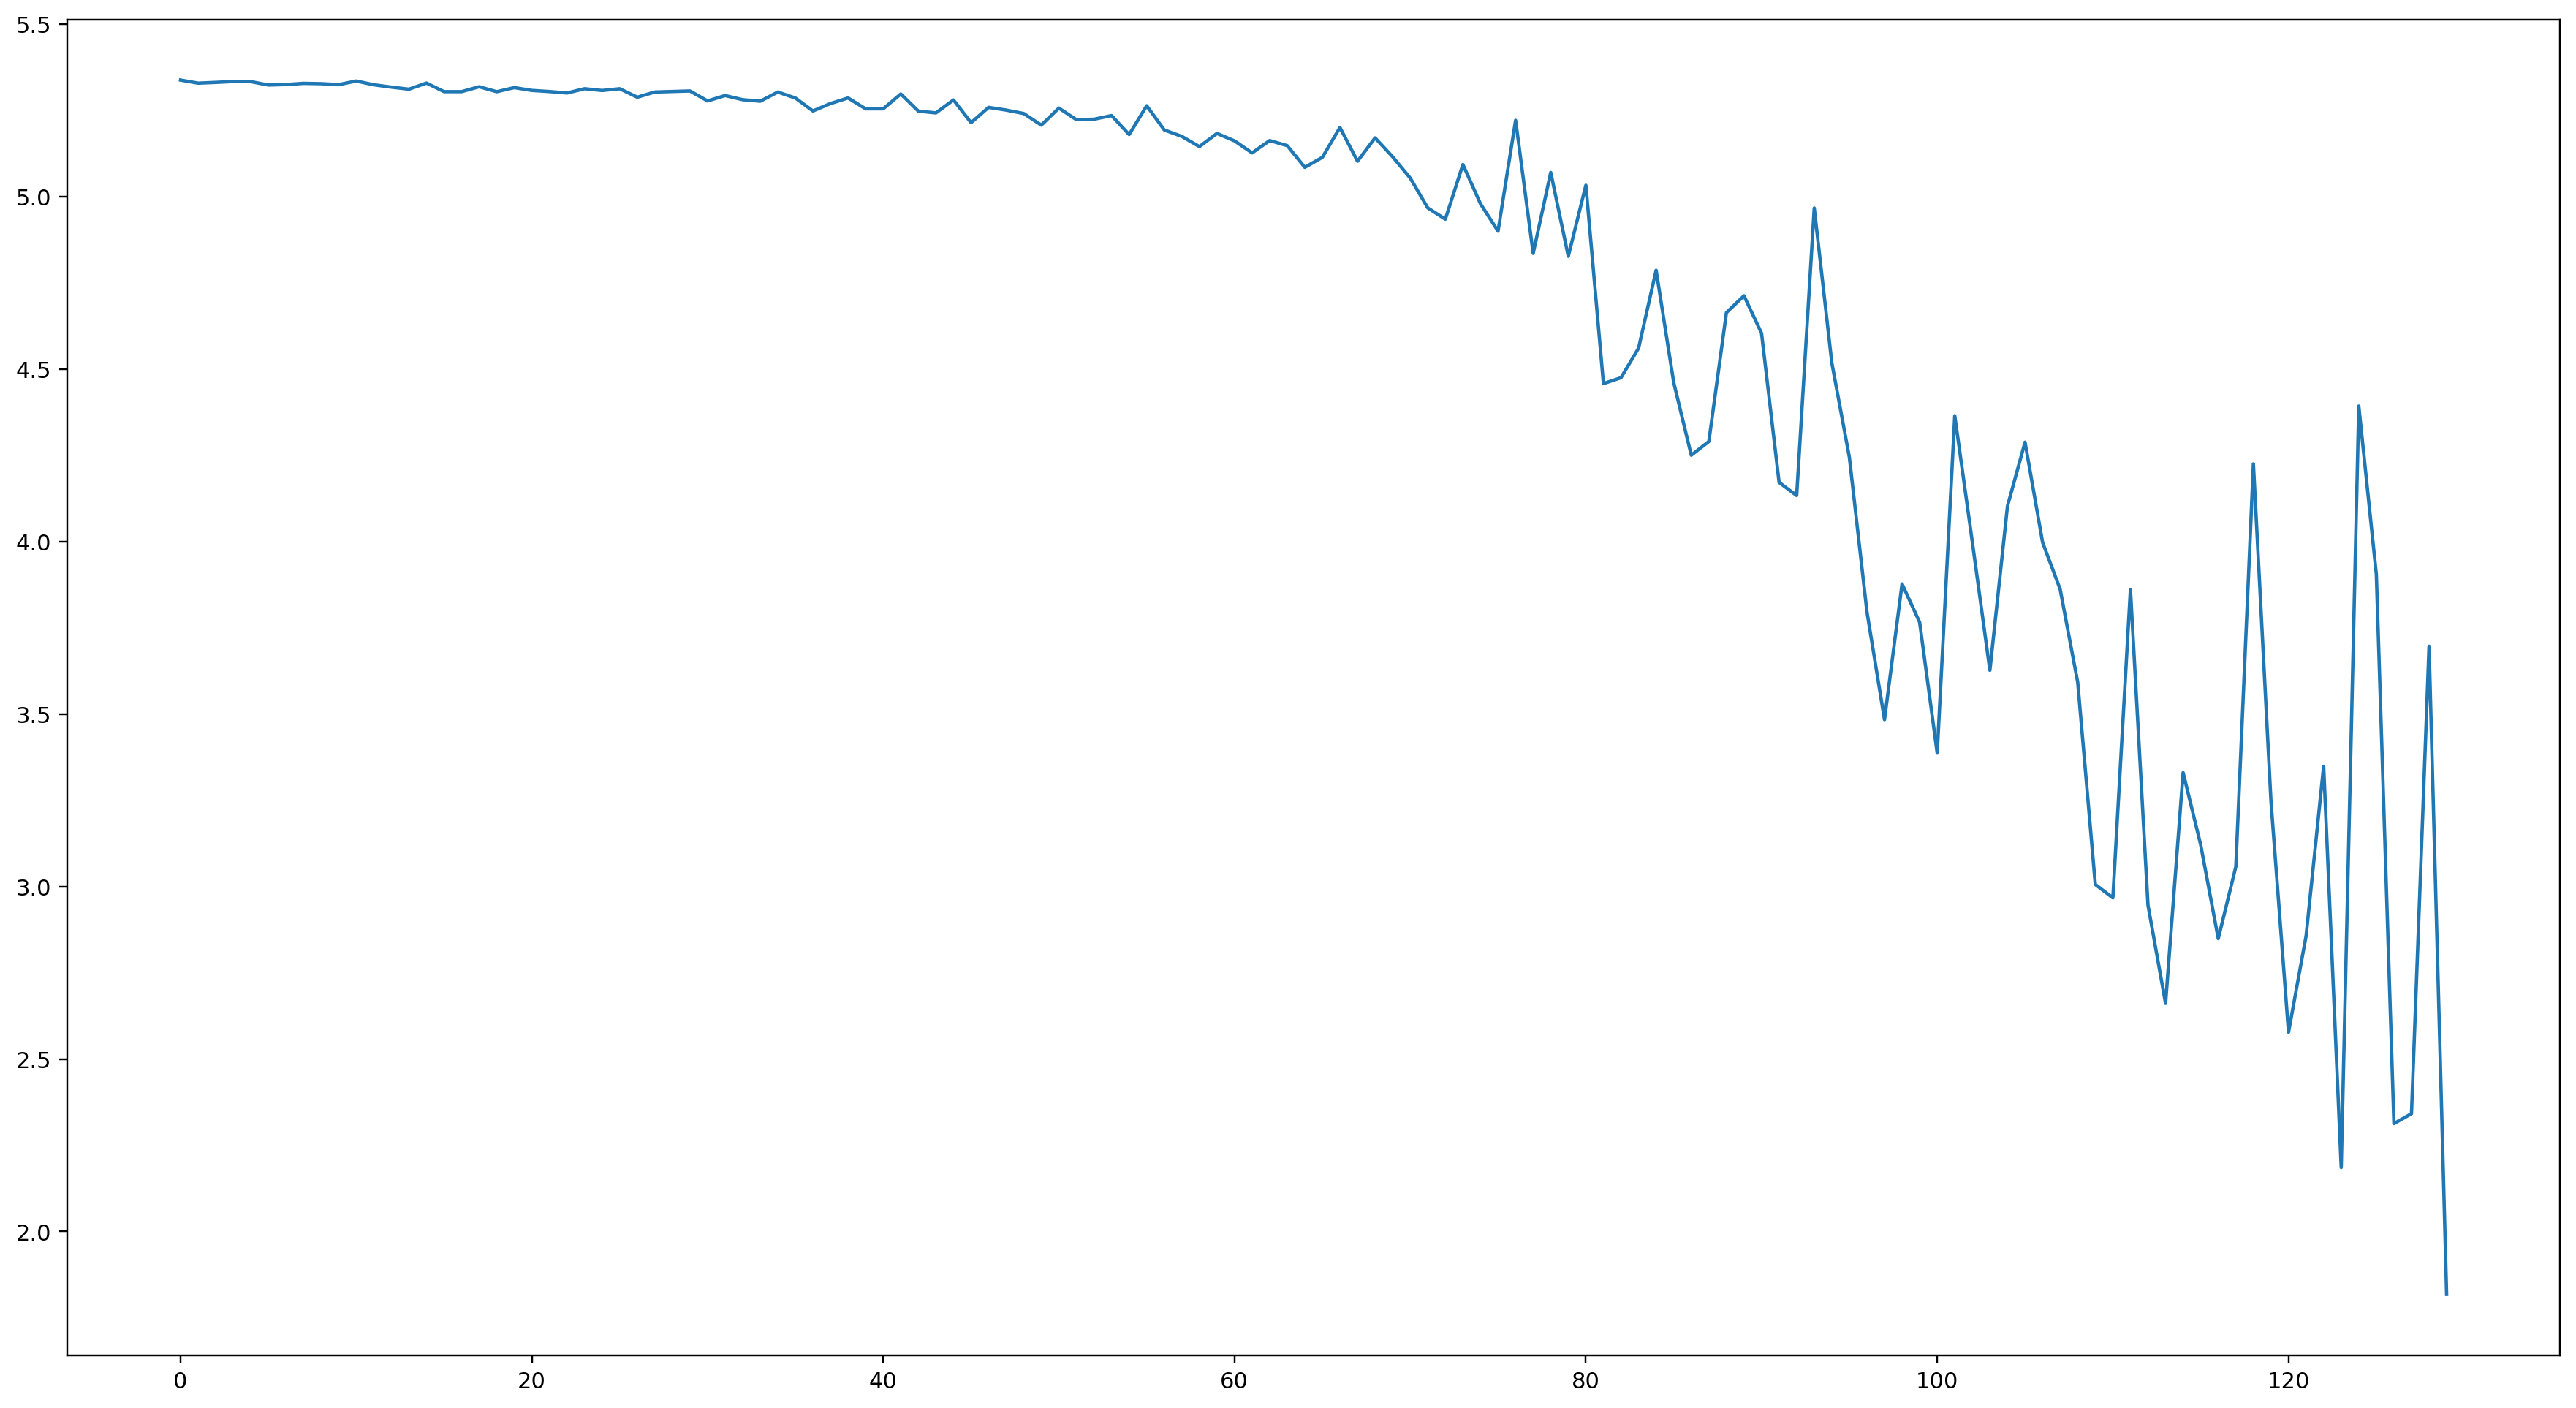

In [81]:
requires_grad=False
total_step = len(train_dl)
t_loss = []
val_losses=[]

def validate(model, data):
    l1= nn.L1Loss()
    for i, (images, labels) in enumerate(data):
        
        
        images = images.to(device)
        images = torch.reshape(images,(images.shape[0]*seq_l,3,64,36))
        labels = labels.to(device)
        x = model(images)
        labels = torch.flatten(labels)
        loss1 = l1(x,labels.to(torch.float))
        
    return loss1

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):  
        
        
        images = images.to(device)
        images = torch.reshape(images,(images.shape[0]*seq_l,3,64,36))
        labels = labels.to(device).to(torch.long)
        labels = torch.flatten(labels)
        #Forward pass
        out = model(images)
        out=torch.reshape(out,(int(images.shape[0]/seq_l),seq_l))
    
        loss_v =[]
        yh_v=[]
        yh_v = torch.tensor(yh_v)

        for i in range(int(images.shape[0]/seq_l)):
        
            yh=yhat(seq_l,(out[i]))
            yh_v=torch.cat((yh_v,yh),0)
        yh_v=torch.reshape(yh_v,(int(images.shape[0]/seq_l),seq_l))

        loss = cost(out,yh_v)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		

    print("loss",epoch,"=====",float(loss) )    
    t_loss.append(float(loss))
from matplotlib.pyplot import figure
    
figure(figsize=(20, 11), dpi=220)    
plt.plot(t_loss) 
plt.plot(val_losses) 

tensor([22., 34., 41., 46., 47., 47., 34., 41., 46., 47., 47., 43., 41., 46.,
        47., 47., 43., 36., 46., 47., 47., 43., 36., 25., 22., 35., 43., 47.,
        49., 49., 35., 43., 47., 49., 49., 45., 43., 47., 49., 49., 45., 38.,
        47., 49., 49., 45., 38., 27., 49., 49., 45., 38., 27., 15., 20., 32.,
        39., 44., 46., 45., 32., 39., 44., 46., 45., 43., 39., 44., 46., 45.,
        43., 39., 44., 46., 45., 43., 39., 31., 46., 45., 43., 39., 31., 20.,
        45., 43., 39., 31., 20.,  4., 16., 30., 40., 46., 49., 50., 30., 40.,
        46., 49., 50., 49., 40., 46., 49., 50., 49., 45., 46., 49., 50., 49.,
        45., 38., 49., 50., 49., 45., 38., 26., 50., 49., 45., 38., 26.,  7.,
        18., 32., 42., 48., 52., 53., 32., 42., 48., 52., 53., 52., 42., 48.,
        52., 53., 52., 48., 48., 52., 53., 52., 48., 41., 52., 53., 52., 48.,
        41., 29., 53., 52., 48., 41., 29., 10.])
performance =  tensor(90.2698) %
L1 error 4.0782585
MsE  =  25.655617


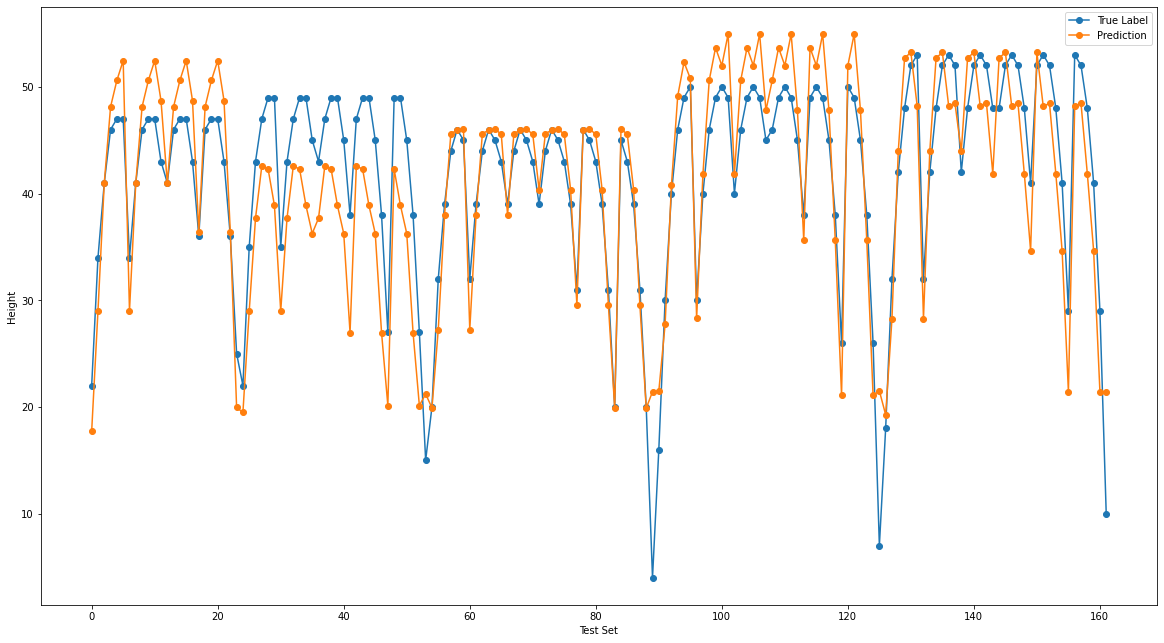

In [82]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
pred = []
pred = torch.tensor(pred)
targets = []
targets = torch.tensor(targets)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images = images.to(device)
        images = torch.reshape(images,(images.shape[0]*seq_l,3,64,36))
        labels = labels.to(device).to(torch.long)
        labels = torch.flatten(labels)

        targets = torch.cat((targets,labels),0)

        outputs = model(images)

        
        pred = torch.cat((pred,(outputs)),0)

print(targets)
figure(figsize=(20, 11))
 
plt.plot(targets,marker='o')
plt.plot(pred+20,marker='o')
plt.xlabel("Test Set")
plt.ylabel("Height")
plt.legend(["True Label","Prediction"])

MAE_svr = mean_absolute_error(targets,pred+20)
err_percent = (MAE_svr/targets.mean())*100
print('performance = ',100-err_percent,'%' )
print("L1 error" , MAE_svr )
L_loss = nn.L1Loss()
r2 = r2_score(targets, pred)
mse = mean_squared_error(targets,pred+20)
print("MsE  = " , mse )
